In [30]:
from IPython.display import clear_output
! pip install nltk gensim pyldavis spacy
clear_output()

In [31]:
! python -m spacy download ru_core_news_sm
clear_output()

# Тематическое моделирование

Текстовый файл можно загрузить [по ссылке](https://raw.githubusercontent.com/trocean11/python_dc/refs/heads/main/Belanovskiy.txt) (нажать Ctrl+S или Cmd+S)

In [32]:
with open('Belanovskiy.txt', encoding='utf-8', mode='r') as file:
  text_a = file.read()
documents = text_a.split('______________')

In [33]:
import nltk
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.util import ngrams
import string
import spacy

# Загрузка необходимых ресурсов
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Задание русских стоп-слов (можно использовать русскоязычные стоп-слова)
stop_words = list(stopwords.words('russian'))

# Загрузка модели spacy для русского языка
nlp = spacy.load("ru_core_news_sm")

# Функция предобработки текста
def preprocess(text):
    # Перевод текста в пространство модели Spacy
    doc = nlp(text)
    # Лемматизация
    tokens = [token.lemma_ for token in doc]
    # Убираем знаки препинания и стоп-слова
    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]
    return tokens

# Применение предобработки ко всем текстам
processed_docs = [preprocess(doc) for doc in documents]

# Формируем биграммы
bigram = gensim.models.Phrases(processed_docs, min_count=1, threshold=2)
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Применяем биграммы
processed_docs_bigrams = [bigram_mod[doc] for doc in processed_docs]

# Создание словаря и корпуса
dictionary = corpora.Dictionary(processed_docs_bigrams)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs_bigrams]

# Применяем TF-IDF фильтрацию
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Стоп, а что такое модель Spacy? Это модель для синтаксического анализа. До этого мы работали с анализом морфологии, а теперь посмотрим на синтаксис. Spacy умеет вот так:

In [34]:
text = "Бесцветные зелёные идеи спят яростно."

doc = nlp(text)

from spacy import displacy

displacy.render(doc, style='dep',jupyter=True)

In [35]:
for token in doc:
    print(token.text, token.dep_, token.head.text) # слово, его синтаксическая роль, его вершина

Бесцветные amod идеи
зелёные amod идеи
идеи nsubj спят
спят ROOT спят
яростно advmod спят
. punct спят


А ещё с помощью Spacy можно легко лемматизировать слова, что мы и сделали.

In [36]:
tokens = [token.lemma_ for token in doc]
tokens

['бесцветный', 'зелёный', 'идея', 'спать', 'яростно', '.']

Ещё один вопрос: а что за TF-IDF? Это метрика, используемая для оценки важности слов в тексте. Для работы LDA-модели нужны **словарь** (список всех слов во всех исследуемых текстах) и **корпус** (статистика важности слов). Обычно в качестве корпуса используется просто "мешок слов" – список слов с количеством вхождений для каждого (чем слово чаще встречается, тем оно "важнее" для данного набора текстов). TF-IDF предоставляет более сложную оценку значимости слов. Подробнее про разницу между "мешком слов" и TF-IDF можно почитать [здесь](https://colab.research.google.com/drive/1P4d45uI5Yk0ctxzNNIYrsL_1RIOa_Sh8#scrollTo=BvfxWVkeweJb).

In [37]:
corpus[0][:10] # для каждого номера слова - его частотность

[(0, 7),
 (1, 7),
 (2, 1),
 (3, 1),
 (4, 4),
 (5, 2),
 (6, 3),
 (7, 3),
 (8, 8),
 (9, 1)]

In [38]:
corpus_tfidf[0][:10] # для каждого номера слова - его значение TF-IDF

[(0, 0.01370853975259508),
 (1, 0.012737275294194543),
 (2, 0.003747363151181691),
 (3, 0.005462930693217597),
 (4, 0.027042829758707126),
 (5, 0.007494726302363382),
 (6, 0.01638879207965279),
 (7, 0.020282122319030347),
 (8, 0.04370344554574078),
 (9, 0.004165153946758415)]

Теперь перейдём непосредственно к LDA-модели. Она делит датасет текстов на интерпретируемые темы (для каждой темы выделяются ключевые слова, по ним можно определить тему).

In [45]:
# Создание LDA модели
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=8, workers=2)

# Просмотр топиков
for idx, topic in lda_model.print_topics(-1, num_words=20): # можно прописать кол-во слов, выводимых для каждой темы; по умолчанию - 10
    print(f"Тема {idx}: {topic}")

Тема 0: 0.000*"мел" + 0.000*"предприятие" + 0.000*"вагон" + 0.000*"спецвагон" + 0.000*"впо" + 0.000*"судно" + 0.000*"лесоматериал" + 0.000*"цемент" + 0.000*"вентили" + 0.000*"госзаказ" + 0.000*"деловой_древесина" + 0.000*"гидролеса" + 0.000*"7_млн" + 0.000*"лес" + 0.000*"министерство" + 0.000*"цистерна" + 0.000*"наш_предприятие" + 0.000*"технический_мел" + 0.000*"начальник_участок" + 0.000*"вентиль"
Тема 1: 0.000*"предприятие" + 0.000*"министерство" + 0.000*"помидор" + 0.000*"подрядчик" + 0.000*"лицензия" + 0.000*"строительство" + 0.000*"экспертиза" + 0.000*"отрасль" + 0.000*"жильё" + 0.000*"продукция" + 0.000*"строительно_монтажный" + 0.000*"бюро" + 0.000*"научно_технический" + 0.000*"наука" + 0.000*"наш_министерство" + 0.000*"ассоциация" + 0.000*"концерн" + 0.000*"общежитие" + 0.000*"институт" + 0.000*"госзаказ"
Тема 2: 0.000*"начальник_участок" + 0.000*"магазин" + 0.000*"предприятие" + 0.000*"материально_ответственный" + 0.000*"остановочный_ремонт" + 0.000*"работник_столовая" + 0.00

In [46]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary, mds="mmds", R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.000505  0.000776       1        1  22.418609
2      0.000573 -0.000874       2        1  16.643558
1      0.000335  0.000620       3        1  16.053242
9     -0.000446 -0.000503       4        1  13.300178
6     -0.000577  0.000107       5        1   9.994459
5      0.000355  0.000295       6        1   7.061936
4      0.000333 -0.000118       7        1   6.357537
7     -0.000163 -0.000159       8        1   5.592299
8      0.000060 -0.000065       9        1   1.289090
0      0.000034 -0.000078      10        1   1.289090, topic_info=                    Term      Freq     Total Category  logprob  loglift
8863   начальник_участок  0.000000  0.000000  Default  10.0000  10.0000
583             водитель  0.000000  0.000000  Default   9.0000   9.0000
8862     начальник_смена  0.000000  0.000000  Default   8.0000   8.0000
22388           комплект  0.000000  0.000000  Default   7.0000   7.0000
14497              шахта  0.000000  0.000000  Default   6.0000   6.0000
...                  ...       ...       ...      ...      ...      ...
21533  деловой_древесина  0.000476  0.041014  Topic10 -10.2561  -0.1043
4112         предприятие  0.000477  0.134721  Topic10 -10.2537  -1.2912
20149                впо  0.000477  0.056269  Topic10 -10.2547  -0.4192
27646              судно  0.000477  0.069706  Topic10 -10.2550  -0.6336
19708           госзаказ  0.000476  0.057804  Topic10 -10.2561  -0.4475

[222 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 10, 7, 6, 5, 8, 9, 1])

Как мы можем интерпретировать получившиеся темы?

## **Подсчет частот слов. Визуализация**


In [41]:
from collections import Counter
import plotly.express as px


# Подсчитываем частоту слов
word_counts = Counter([word for text in processed_docs for word in text])

# Получаем 10 самых популярных слов
word_data = word_counts.most_common(10)

# Визуализируем частоту слов
fig_word = px.bar(x=[item[0] for item in word_data], y=[item[1] for item in word_data],
                  title="Самые распространенные слова", labels={"x": "Слово", "y": "Частота"})

# Отображаем графики
fig_word.show()


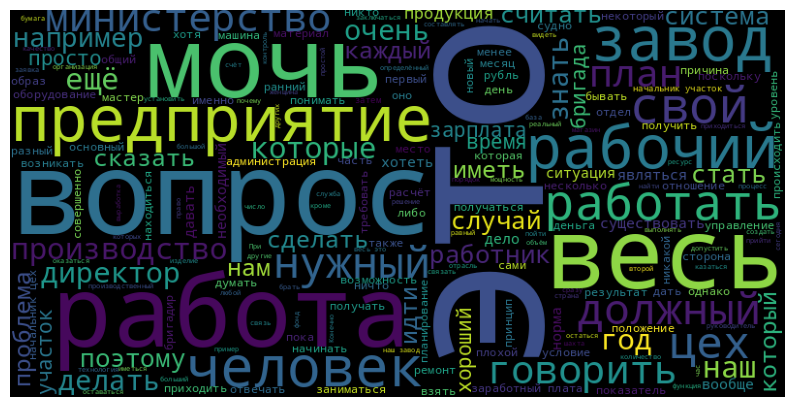

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_data = ' '.join([word for text in processed_docs for word in text]) # делаем строку из списка списков
wordcloud = WordCloud(width=800,
                      height=400).generate(text_data) # сюда подаём строку, wordcloud сам посчитает частотность
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Дополнительные материалы

Подробнее о том, как работает LDA, можно почитать тут: [часть 1](https://habr.com/ru/companies/surfingbird/articles/228249/), [часть 2](https://habr.com/ru/companies/surfingbird/articles/228249/).